<a href="https://colab.research.google.com/github/aldofranco91/Trading/blob/main/Conv_Regression_ResNet_Jaime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb 10 22:38:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install yfinance

In [4]:
import matplotlib
# importing the requests library 
import requests 
import pandas as pd
import numpy as np
import time
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pickle import dump, load

from IPython import display

import tensorflow as tf

from sklearn import metrics
from scipy import stats

tf.keras.utils.set_random_seed(9)
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

# Get data

In [6]:
folder = '/content/drive/MyDrive/Trading/5_days_v2/'
past_t = 14
forecast_t = 5

In [7]:
import yfinance as yf
import datetime as dt

start = dt.datetime(2018,2,1)
end = dt.datetime.now() - dt.timedelta(days=1)

df = yf.download('BTC-USD', start, end).drop('Adj Close', axis=1)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2018-02-01,10237.299805,10288.799805,8812.280273,9170.540039,9959400448
2018-02-02,9142.280273,9142.280273,7796.490234,8830.750000,12726899712
2018-02-03,8852.120117,9430.750000,8251.629883,9174.910156,7263790080
2018-02-04,9175.700195,9334.870117,8031.220215,8277.009766,7073549824
2018-02-05,8270.540039,8364.839844,6756.680176,6955.270020,9285289984
...,...,...,...,...,...
2022-02-05,41501.480469,41847.164062,41038.097656,41441.164062,19652846215
2022-02-06,41441.121094,42500.785156,41244.906250,42412.433594,16142097334
2022-02-07,42406.781250,44401.863281,41748.156250,43840.285156,28641855926


# Indicators

https://www.ig.com/es/estrategias-de-trading/los-10-mejores-indicadores-de-trading-para-inversores-190830

In [8]:
# Fear index
df_fear = pd.read_csv('/content/drive/MyDrive/Trading/fear_index.csv')
df_fear = df_fear[df_fear.date.between('2018-02-01', '2022-01-31')]
df_fear['date'] = pd.to_datetime(df_fear['date'])
df['date'] = pd.to_datetime(df.index)
df = df.join(df_fear.set_index('date'), on='date')
df = df.drop(['date'], axis=1)
df['value'] = df['value'].fillna(25) # Fill 3 consequtive days taking sorrounding values (23-26)

In [9]:
price = 'Close'

# MovingAverage
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
values_ma = range(2,30,2)
for i in values_ma:
    df["maclose" + str(i)] = df[price].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = range(2,30,2)
for i in values_ema:
    df["ema" + str(i)] = df[price].ewm(span = i, adjust = False).mean()

# Wight Moving Average
# https://predictivehacks.com/?all-tips=how-to-apply-a-rolling-weighted-moving-average-in-pandas
weights = np.array([0.1, 0.2, 0.3, 0.4]) #Tienen que sumar 1 🙂
df['wma'] = df[price].rolling(4).apply(lambda x: np.sum(weights*x))

# RSI
# https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = range(2,30,2)
close = df[price]

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    roll_up1 = up.ewm(span=i).mean()
    roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))

    df["rsiewma" + str(i)] = RSI1.values
    df["rsisma" + str(i)]  = RSI2.values

# BollingerBand
values_bollinger = range(2,30,2)
for i in values_bollinger:
    df['bollingerupper' + str(i)] = df[price].rolling(window=i).mean() + (df[price].rolling(window=i).std() * 2)
    df['bollingerlower' + str(i)] = df[price].rolling(window=i).mean() - (df[price].rolling(window=i).std() * 2)

In [10]:
df = df.dropna()
df.tail(5)

,Open,High,Low,Close,Volume,value,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-05,41501.480469,41847.164062,41038.097656,41441.164062,19652846215,25.0,41471.019531,39262.406250,39046.003906,38791.475586,38525.437109,38255.041341,37999.402065,37717.449707,38105.774523,38526.506250,38946.427379,39271.361328,39584.524189,39747.517578,40990.946124,40046.556666,39506.723344,39194.982071,39035.797692,38985.328002,39013.067376,39097.336798,39222.783904,39378.537304,39556.828687,39751.998904,39959.808260,40176.974336,40152.946875,92.121069,98.644776,85.801654,71.084220,81.514834,74.389368,77.920703,73.447278,74.517428,76.282579,71.317541,76.209827,68.381357,79.802026,65.733542,52.318499,63.368888,47.418768,61.266889,45.618786,59.401554,45.687826,57.746555,44.056036,56.277513,49.181683,54.972755,49.376867,41555.463549,41386.575514,44365.868859,34158.943641,43058.962540,35033.045273,42313.565516,35269.385656,41841.977175,35208.897044,41510.289292,34999.793391,41267.030739,34731.773390,41167.028572,34267.870842,42073.410612,34138.138433,43086.622475,33966.390025,44065.394506,33827.460252,44637.484414,33905.238242,45197.465956,33971.582421,45279.664476,34215.370680
2022-02-06,41441.121094,42500.785156,41244.906250,42412.433594,16142097334,25.0,41926.798828,40627.268555,39700.888672,39325.757324,39052.857031,38709.910482,38437.661272,38089.644531,38142.891493,38534.600391,38911.656250,39263.897298,39572.084886,39765.404436,41938.604437,40992.907437,40336.926272,39909.971298,39649.731492,39512.575016,39466.316205,39487.348186,39558.536503,39667.479808,39805.142157,39964.833679,40141.484210,40331.143940,41412.957812,97.203457,94.208335,90.526092,98.929695,85.958511,75.751407,82.215103,75.395399,78.729057,78.008498,75.456115,77.839610,72.434950,79.271500,69.686375,72.635850,67.207732,51.811450,64.982562,50.421623,62.988673,48.099411,61.202815,49.567517,59.602943,49.305396,58.169087,51.031114,43300.381372,40553.216284,45342.045944,35912.491165,44481.898447,34919.878897,43609.269977,35042.244671,43005.433013,35100.281049,42629.516147,34790.304817,42301.499557,34573.822988,42183.931698,33995.357364,42264.213970,34021.569016,43123.035470,33946.165311,43919.375294,33903.937206,44611.209550,33916.585047,45157.338759,33986.831013,45329.721204,34201.087669
2022-02-07,42406.781250,44401.863281,41748.156250,43840.285156,28641855926,25.0,43126.359375,42298.689453,40550.390625,40066.092773,39658.452344,39292.257487,38950.943917,38640.271729,38318.439670,38607.833008,38944.674716,39294.755046,39567.899639,39837.512416,43206.391583,42131.858525,41337.885954,40783.374378,40411.650340,40178.376576,40049.512066,39999.458417,40009.246888,40064.889841,40156.024157,40274.869797,40415.469466,40573.153679,42698.164453,99.272659,100.000000,94.781008,99.122557,90.606162,78.970131,86.995780,80.774594,83.599405,79.694460,80.375646,81.395287,77.358639,81.159624,74.573249,83.485610,72.024694,58.401612,69.704707,53.572264,67.598210,51.690201,65.687685,51.711944,63.955540,49.768433,62.3

# Create sequences

In [11]:
#columns = ["prices", "total_volumes", "market_caps", "ema_5", "ema_10", "ema_15", "ema_30"]
columns = df.columns

df_rs = np.array(df[columns])
df_rs.shape

(1442, 91)

In [12]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    range = np.arange(start = 0, stop = len(sequence), step = 1) # Ojo con el step que te fundio :)
    for i in range:
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix][:,df.columns.get_loc(price)]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [13]:
n_steps_in = past_t
n_steps_out = forecast_t
# split into samples
X, y = split_sequence(df_rs, n_steps_in, n_steps_out)
print("Shape X --> " + str(X.shape))
print("Shape y --> " + str(y.shape))

print("Example of day -->")
pd.DataFrame(X[-1], columns=columns)

Shape X --> (1424, 14, 91)
Shape y --> (1424, 5)
Example of day -->


,Open,High,Low,Close,Volume,value,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
0,36471.589844,36688.812500,34349.250000,35030.250000,3.971439e+10,13.0,35743.783203,38478.078125,39756.416016,40603.721680,41052.104297,41433.833333,41495.633092,41514.419189,41720.035590,42165.816602,42652.198331,42993.038900,43302.557692,43832.729771,36023.045657,37746.870741,38839.516349,39585.402368,40153.683350,40625.589766,41040.098178,41417.407903,41769.116950,42102.441017,42422.034594,42730.880767,43030.808654,43322.842315,37259.811328,0.056445,0.000000,0.825030,0.000000,2.568674,1.500902,4.745686,2.392696,6.949095,6.874893,9.033789,22.767352,10.967386,23.683173,12.751365,21.993263,14.394979,18.504568,15.908768,17.072042,17.303434,22.391807,18.589691,24.089750,19.778084,20.235311,20.878727,21.238674,37761.959869,33725.606537,44957.757804,31998.398446,46150.618544,33362.213488,46852.815106,34354.628253,46883.457161,35220.751433,47025.695211,35841.971455,46649.106073,36342.160110,46313.570334,36715.268045,46386.329073,37053.742107,47366.374977,36965.258226,48516.874012,36787.522650,49059.627478,36926.450322,49527.216121,37077.899264,50976.679619,36688.779923
1,35047.359375,36433.312500,34784.968750,36276.804688,2.601798e+10,11.0,35653.527344,37111.197266,38760.791667,39741.147461,40420.627734,40895.579102,41093.147600,41184.350586,41314.913411,41656.750977,42133.561612,42538.817220,42867.478816,43313.704381,36192.218344,37158.844320,38107.313017,38850.158439,39448.796320,39956.545908,40404.992379,40812.631054,41190.978817,41547.618509,41887.666776,42214.554681,42530.512064,42836.908686,36379.301953,55.663070,46.624209,31.664299,15.658990,25.649411,15.735157,23.655113,14.222891,23.065975,19.135124,23.075098,24.770265,23.374697,29.592064,23.826476,31.350878,24.358764,27.451744,24.930567,23.290463,25.517333,21.879931,26.104300,25.817901,26.682844,26.836296,27.248222,23.709091,37416.421889,33890.632798,42036.431487,32185.963044,45151.200866,32370.382468,46265.198327,33217.096595,46848.221919,33993.033550,47145.309259,34645.848944,46940.162313,35246.132888,46650.782311,35717.918861,46534.708323,36095.118500,47076.815960,36236.685993,48148.643683,36118.479541,48921.693060,36155.941380,49418.595371,36316.362261,50466.706840,36160.701922
2,36275.734375,37247.519531,33184.058594,36654.328125,4.185666e+10,13.0,36465.566406,36104.674805,37807.240885,38933.703613,39776.090625,40287.681315,40724.080915,40866.874756,40953.435547,41194.588672,41647.612038,42136.645671,42490.925631,42814.201172,36500.291531,36957.037842,37692.174476,38362.196147,38940.711194,39448.512403,39904.903812,40323.418945,40713.436639,41081.590853,41432.593850,41769.736556,42095.239179,42410.523820,36196.554297,70.550130,100.000000,40.935018,22.326412,32.435652,18.106753,29.133020,17.565604,27.701234,18.089347,27.102486,19.515563,26.932901,31.667906,27.006735,32.314051,27.225842,29.842812,27.533009,25.516267,27.892973,23.698781,28.283470,28.109049,28.690365,29.302391,29.104726,24.887354,36999.465172,35931.667641,37570.049491,34639.300118,43244.977161,32369.504610,45140.754036,32726.653191,46301.58706

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

test_size = 200
train_size = len(X) - test_size
X_train = X[0:train_size]
y_train = y[0:train_size]
X_test_og = X[train_size:len(X)]
y_test = y[train_size:len(X)]

#scaler = MinMaxScaler(feature_range=(-1,1)) #Try this
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test_og.reshape(-1, X_test_og.shape[-1])).reshape(X_test_og.shape)
X_new = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
# save the scaler
dump(scaler, open(folder + 'scaler.pkl', 'wb'))

print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))
print("Example of day -->")
pd.DataFrame(X_train[-1], columns=columns)

Shape X_train --> (1224, 14, 91)
Shape y_train --> (1224, 5)
Shape X_test  --> (200, 14, 91)
Shape y_test  --> (200, 5)
Example of day -->


,Open,High,Low,Close,Volume,value,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
0,1.355182,1.374865,1.433416,1.388804,0.046446,-1.118597,1.373476,1.411059,1.396757,1.421366,1.424756,1.397383,1.401691,1.387293,1.404779,1.428424,1.464274,1.496519,1.506929,1.519404,1.389207,1.398788,1.404349,1.409122,1.415076,1.422621,1.431691,1.442198,1.454113,1.467433,1.482146,1.498213,1.515566,1.534113,1.399815,0.006882,-0.746813,-0.178125,0.072610,-0.183116,-0.391075,-0.181554,-0.165678,-0.191817,0.354697,-0.210464,-0.203215,-0.233435,0.157503,-0.258616,-0.333985,-0.285075,-0.355694,-0.312352,-0.668314,-0.340126,-0.865761,-0.368101,-0.290218,-0.395990,-0.402058,-0.423526,-0.090165,1.316202,1.431281,1.342332,1.486109,1.295061,1.513063,1.312647,1.547805,1.280259,1.597226,1.296947,1.515560,1.270937,1.559893,1.257210,1.545620,1.262914,1.579260,1.298568,1.586271,1.382139,1.554892,1.435405,1.555661,1.423173,1.596363,1.415343,1.636561
1,1.390215,1.372104,1.450801,1.362320,-0.029491,-0.769146,1.377290,1.396855,1.400059,1.403743,1.419183,1.410367,1.402356,1.396888,1.397877,1.413589,1.443198,1.481035,1.497430,1.510543,1.372622,1.386468,1.395015,1.401637,1.408561,1.416544,1.425741,1.436187,1.447918,1.460967,1.475346,1.491037,1.507986,1.526114,1.382243,-0.746216,0.070833,-0.567762,-0.524427,-0.468381,0.033081,-0.408218,-0.777871,-0.379356,-0.348818,-0.370110,0.376689,-0.372317,-0.108588,-0.381480,0.220084,-0.395211,-0.382200,-0.412129,-0.677356,-0.431310,-0.928072,-0.452048,-0.765931,-0.473768,-0.505865,-0.495992,-0.505675,1.309554,1.446579,1.335377,1.463576,1.291723,1.524276,1.274201,1.555764,1.278997,1.586284,1.274899,1.573280,1.271155,1.561135,1.248300,1.579702,1.249902,1.580691,1.254049,1.612307,1.315781,1.596990,1.406469,1.559352,1.412645,1.588513,1.406345,1.628086
2,1.366769,1.298487,1.326893,1.294135,0.198261,-1.118597,1.329918,1.354752,1.388170,1.384797,1.408260,1.414413,1.393385,1.398525,1.386817,1.403306,1.425601,1.459353,1.490125,1.500830,1.321592,1.351727,1.368780,1.380567,1.390734,1.400807,1.411386,1.422752,1.435085,1.448507,1.463091,1.478860,1.495794,1.513839,1.343032,-1.331628,-1.358376,-1.209772,-1.244541,-1.042561,-0.502989,-0.907965,-0.811553,-0.813900,-0.531236,-0.751258,0.025409,-0.710365,-0.446546,-0.684512,-0.076226,-0.669421,-0.512080,-0.662282,-0.535132,-0.661130,-0.827562,-0.664496,-1.016212,-0.671241,-0.431696,-0.680455,-0.535284,1.320656,1.335117,1.279313,1.437727,1.310554,1.475775,1.268151,1.521116,1.288324,1.550051,1.262725,1.598055,1.267555,1.545233,1.246136,1.586373,1.233771,1.576615,1.241378,1.605440,1.277032,1.609027,1.358241,1.575348,1.411314,1.572860,1.401377,1.611757
3,1.295058,1.307565,1.340379,1.358323,0.088072,-1.118597,1.327919,1.355661,1.378019,1.386775,1.393739,1.409427,1.404241,1.398855,1.395134,1.396882,1.411910,1.439835,1.475654,1.491850,1.347417,1.356628,1.368462,1.378534,1.387912,1.397465,1.407604,1.418553,1.430466,1.443456,1.457594,1.472906,1.489376,1.506956,1.346371,0.502743,-0.127191,0.054395,-0.057515,-0.114763,-0.433188,-0.187967,-0.028750,-0.229111,-0.701122,-0.259313,-0.339406,-0.285424,0.310439,-0.309982,-0.124166,-0.

# Model 

Transfer learning work-flow

https://keras.io/guides/transfer_learning/ (The typical transfer-learning workflow)

In [15]:
from tensorflow.keras import backend as K 

def euc_dist_keras(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

def max_distance(y_true, y_pred):
    return K.max(K.abs(y_true - y_pred), axis=-1, keepdims=True)

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import activations

Gan inspiration

https://keras.io/examples/generative/conditional_gan/

In [23]:
# Get square shape
image_shape = X_train.shape[1]

if X_train.shape[1]<X_train.shape[2]:
  image_shape = X_train.shape[2]

# Load Resnet model
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(image_shape, image_shape, 3),
    include_top=False) 
base_model.trainable = False

# Create input as image
inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
if X_train.shape[1]<X_train.shape[2]:
  input_img = layers.Reshape((X_train.shape[2], X_train.shape[1]))(inputs) 
  input_img = layers.Dense(image_shape, activation='relu')(input_img) # Create a square matrix 
  input_img = layers.Reshape((image_shape, image_shape, 1))(input_img) # Reshape into an image with 1 channels
  input_img = layers.Dense(3, activation='tanh', name='image_inp')(input_img) # Learn 3 channels
else:
  input_img = layers.Dense(image_shape, activation='relu')(inputs) # Create a square matrix 
  input_img = layers.Reshape((image_shape, image_shape, 1))(input_img) # Reshape into an image with 1 channels
  input_img = layers.Dense(3, activation='tanh', name='image_inp')(input_img) # Learn 3 channels
# With tahn all outputs are between -1 and 1 (ResNet needs that)

# Create Model
#input_img = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1, name='image_inp')(input_img)
x = base_model(input_img, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x) 

# Output layer
predictions = layers.Dense(y_train.shape[1])(x) #Relu for getting positive values
model = tf.keras.Model(inputs, predictions)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 14, 91)]          0         
                                                                 
 reshape_6 (Reshape)         (None, 91, 14)            0         
                                                                 
 dense_9 (Dense)             (None, 91, 91)            1365      
                                                                 
 reshape_7 (Reshape)         (None, 91, 91, 1)         0         
                                                                 
 image_inp (Dense)           (None, 91, 91, 3)         6         
                                                                 
 resnet152v2 (Functional)    (None, 3, 3, 2048)        58331648  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0   

In [24]:
#tf.keras.utils.plot_model(model, to_file="model.png")

In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss', patience=7, verbose=1, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=1, factor=0.5, min_lr=5e-5)

In [26]:
history = model.fit(X_train, y_train, epochs = 300, batch_size = 8, 
                    callbacks=[learning_rate_reduction, early_stopping],
                    validation_data= (X_test, y_test))

Epoch 1/300
39/39 [==============================] - 18s 173ms/step - loss: 14295.4473 - mae: 14295.4473 - val_loss: 48641.3164 - val_mae: 48641.3164 - lr: 0.0100
Epoch 2/300
39/39 [==============================] - 4s 113ms/step - loss: 13507.1572 - mae: 13507.1572 - val_loss: 48009.4062 - val_mae: 48009.4062 - lr: 0.0100
Epoch 3/300
39/39 [==============================] - 4s 112ms/step - loss: 12356.0850 - mae: 12356.0850 - val_loss: 47396.0703 - val_mae: 47396.0703 - lr: 0.0100
Epoch 4/300
39/39 [==============================] - 5s 122ms/step - loss: 10947.8320 - mae: 10947.8320 - val_loss: 46299.1914 - val_mae: 46299.1914 - lr: 0.0100
Epoch 5/300
39/39 [==============================] - 4s 113ms/step - loss: 9659.3447 - mae: 9659.3447 - val_loss: 44631.2188 - val_mae: 44631.2188 - lr: 0.0100
Epoch 6/300
39/39 [==============================] - 4s 113ms/step - loss: 8770.8848 - mae: 8770.8848 - val_loss: 43512.6133 - val_mae: 43512.6133 - lr: 0.0100
Epoch 7/300
39/39 [============

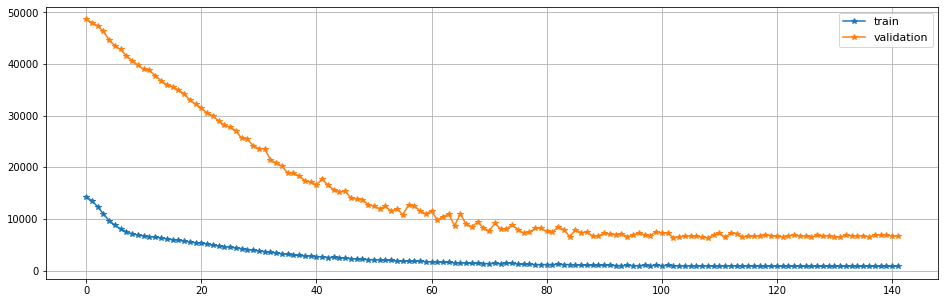

In [27]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

## Fine-tuning

In [28]:
model_path = folder + 'modelo_best.h5'
checkpoint = ModelCheckpoint(model_path, monitor="val_loss",
                             save_freq = 'epoch', save_best_only=True, mode='min') 
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=1, factor=0.5, min_lr=1.25e-6)

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# Very low learning rate 
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics='mae') 

history = model.fit(X_train, y_train, epochs = 50, batch_size = 8,
                    validation_data= (X_test, y_test),
                    callbacks=[learning_rate_reduction, early_stopping, checkpoint])

Epoch 1/100
39/39 [==============================] - 34s 445ms/step - loss: 0.0344 - mae: 1627.1643 - val_loss: 0.0314 - val_mae: 7295.8589 - lr: 1.0000e-05
Epoch 2/100
39/39 [==============================] - 16s 411ms/step - loss: 0.0077 - mae: 899.9255 - val_loss: 0.0190 - val_mae: 5624.2637 - lr: 1.0000e-05
Epoch 3/100
39/39 [==============================] - 12s 304ms/step - loss: 0.0056 - mae: 777.4030 - val_loss: 0.0156 - val_mae: 4916.1079 - lr: 1.0000e-05
Epoch 4/100
39/39 [==============================] - 6s 154ms/step - loss: 0.0051 - mae: 797.2170 - val_loss: 0.0179 - val_mae: 5391.0068 - lr: 1.0000e-05
Epoch 5/100
39/39 [==============================] - 6s 157ms/step - loss: 0.0056 - mae: 861.0956 - val_loss: 0.0238 - val_mae: 6369.4414 - lr: 1.0000e-05
Epoch 6/100
39/39 [==============================] - 12s 312ms/step - loss: 0.0047 - mae: 762.7405 - val_loss: 0.0146 - val_mae: 4862.6997 - lr: 1.0000e-05
Epoch 7/100
39/39 [==============================] - 6s 155ms/ste

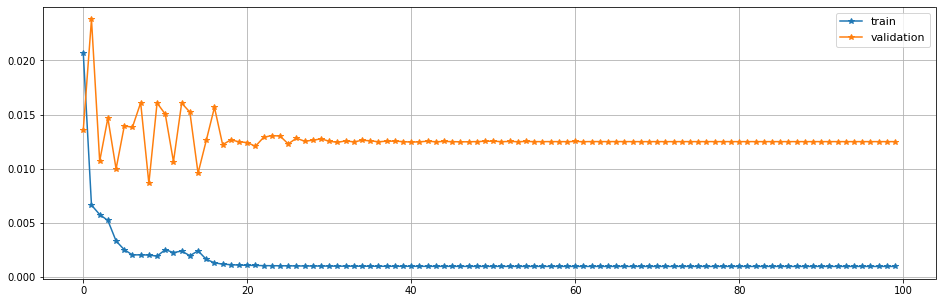

In [55]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

In [56]:
best_model = tf.keras.models.load_model(model_path)
best_model.evaluate(X_test, y_test)

7/7 [==============================] - 3s 50ms/step - loss: 0.0087 - mae: 3636.4668


[0.008658461272716522, 3636.466796875]

# Images created 

In [57]:
sub_model = tf.keras.Model(inputs=best_model.input, outputs=best_model.get_layer('image_inp').output)
sub_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
layer_output = sub_model.predict(X_new, verbose=1)

45/45 [==============================] - 0s 2ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Image Input 1000')

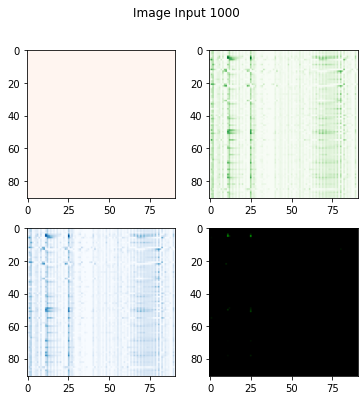

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs[0,0].imshow(layer_output[1000][:,:,0], cmap='Reds')
axs[0,1].imshow(layer_output[1000][:,:,1], cmap='Greens')
axs[1,0].imshow(layer_output[1000][:,:,1], cmap='Blues')
axs[1,1].imshow(layer_output[1000])
fig.suptitle('Image Input 1000', fontsize=12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


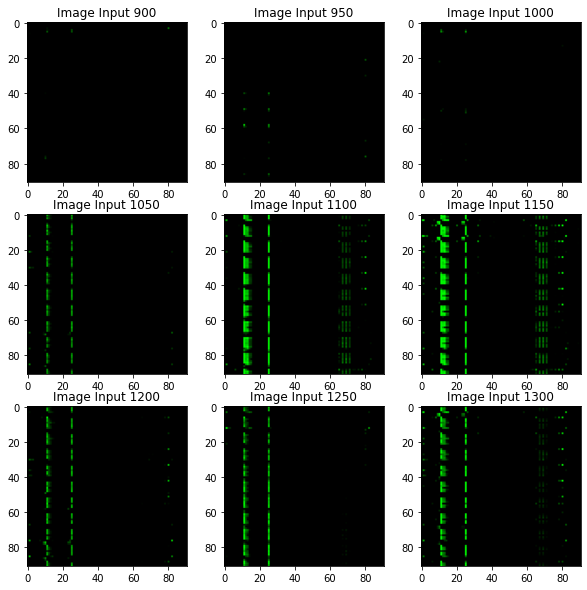

In [59]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for idx,i in enumerate(range(900,1350,50)):
  axs.flat[idx].imshow(layer_output[i])
  axs.flat[idx].set_title('Image Input ' + str(i))

# Results

Dummy regressor

In [117]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train[:,0])
y_dummy = dummy_regr.predict(X_test)
#y_dummy = X_test_og[:,-1, 3] #The price in 5 days is the same as today
mean_absolute_error(y_test[:,4], y_dummy)

34851.52462694994

In [66]:
y_pred_test = best_model.predict(X_test, verbose=1)
y_pred_redes = best_model.predict(X_new, verbose=1)

45/45 [==============================] - 3s 58ms/step


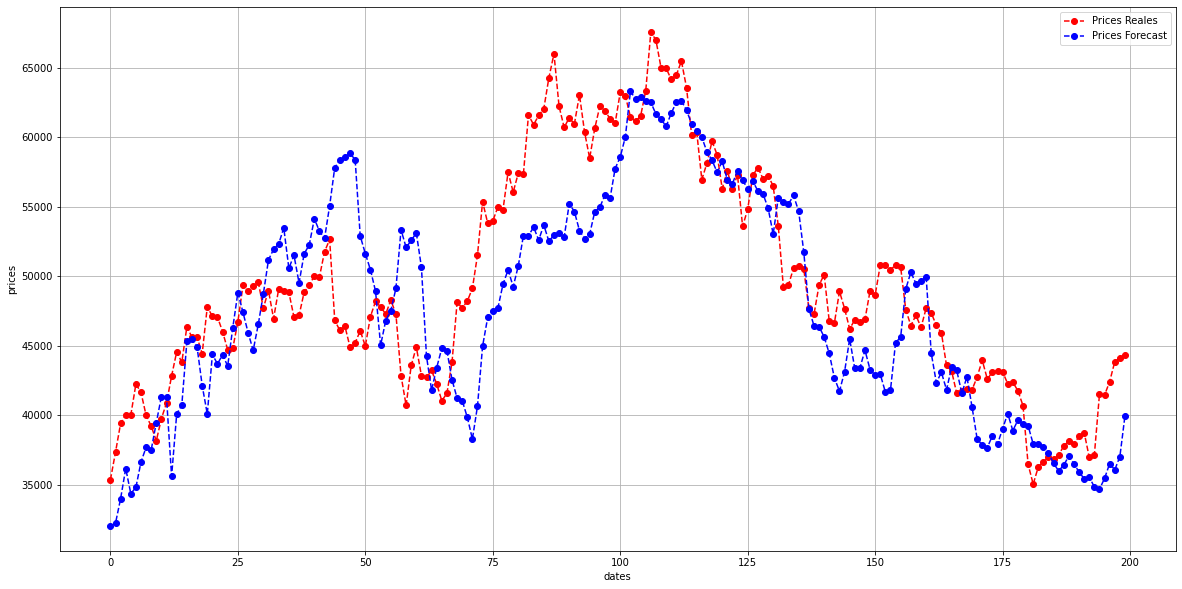

In [118]:
c = 200
day_pred = 4

fig=plt.figure(figsize=(20, 10))
plt.plot(y_test[:, day_pred], '--bo', label = 'Prices Reales', color = "r")
plt.plot(y_pred_test[:, day_pred], '--bo', label = 'Prices Forecast', color = "b")
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)
plt.savefig('imagen.png', dpi = 200)
plt.show()

In [68]:
y_test_original = y_test
y_pred_test = y_pred_test

y_original = y
y_pred_full = y_pred_redes

In [69]:
for i in range(0,len(y_test[0])):
  print('Errors day ' + str(i) + ': ' + str(mean_absolute_error(y_test[:,i], y_pred_test[:,i])))

Errors day 0: 3169.58923828125
Errors day 1: 3366.4340625
Errors day 2: 3626.75060546875
Errors day 3: 3887.119140625
Errors day 4: 4132.4433984375


In [ ]:
errores_test = np.empty([len(y_test)])
for i in range(0,len(y_test)):
    errores_test[i] = np.linalg.norm(y_test_original[i] - y_pred_test[i], np.inf)

errores_full = np.empty([len(y)])
for i in range(0,len(y)):
    errores_full[i] = np.linalg.norm(y_original[i] - y_pred_full[i], np.inf)

In [ ]:
print("Errores Test")
print(pd.DataFrame(errores_test).describe().transpose().round(2))
print("Errores Full")
print(pd.DataFrame(errores_full).describe().transpose().round(2))

Errores Test
   count    mean     std    min      25%      50%      75%       max
0  200.0  4992.4  3067.8  800.5  2666.74  4039.49  6611.46  15373.61
Errores Full
    count     mean      std    min     25%     50%      75%       max
0  1427.0  1708.94  2094.91  48.99  490.67  798.11  2222.74  15373.61


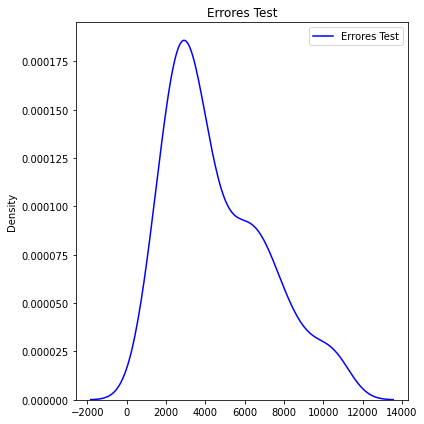

In [ ]:
plt.figure(figsize=(6,6))
sns.kdeplot(errores_test[errores_test < np.percentile(errores_test, 95)], color = "blue", label = 'Errores Test')
plt.title('Errores Test')
plt.tight_layout()
plt.legend()
plt.show()

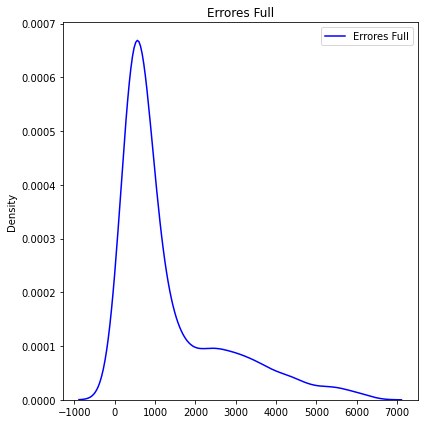

In [ ]:
plt.figure(figsize=(6,6))
sns.kdeplot(errores_full[errores_full < np.percentile(errores_full, 95)], color = "blue", label = 'Errores Full')
plt.title('Errores Full')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
best_redes_test = np.argmin(errores_test)
worse_redes_test = np.argmax(errores_test)

best_redes_full = np.argmin(errores_full)
worse_redes_full = np.argmax(errores_full)

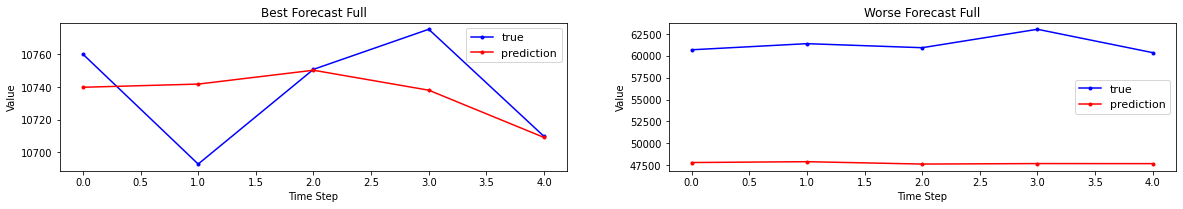

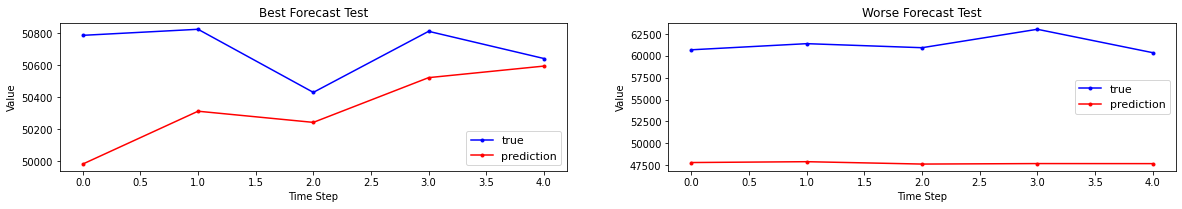

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(221)
plt.title("Best Forecast Full")
plt.plot(y_original[best_redes_full], color = "blue", marker='.', label="true")
plt.plot(y_pred_full[best_redes_full], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(222)
plt.title("Worse Forecast Full")
plt.plot(y_original[worse_redes_full], color = "blue", marker='.', label="true")
plt.plot(y_pred_full[worse_redes_full], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.figure(figsize=(20, 6))
plt.subplot(223)
plt.title("Best Forecast Test")
plt.plot(y_test_original[best_redes_test],  color = "blue", marker='.', label="true")
plt.plot(y_pred_test[best_redes_test], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(224)
plt.title("Worse Forecast Test")
plt.plot(y_test_original[worse_redes_test], color = "blue", marker='.', label="true")
plt.plot(y_pred_test[worse_redes_test], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11) 
plt.show();